Dataset loaded successfully!
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       1  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

===== BASELINE DECISION STUMP =====
Train Accuracy : 0.7681159420289855
Test Accuracy  : 0.6888888888888889

Confusion Matrix (Test):
 [[38 11]
 [17 24]]

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.69      0.78      0.73        49
           1       0.69      0.5

/Users/ak/Desktop/Sem 5/ML/UML501/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/ak/Desktop/Sem 5/ML/UML501/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/ak/Desktop/Sem 5/ML/UML501/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/ak/Desktop/Sem 5/ML/UML501/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/ak/Desktop/Sem 5/ML/UML501/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but Decision

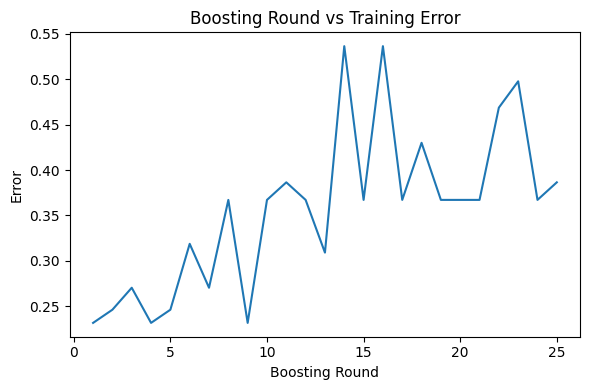

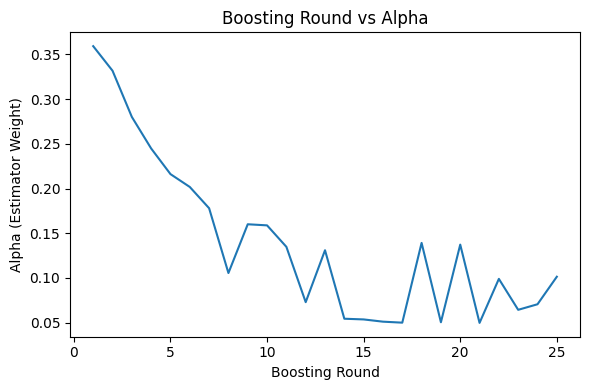


===== FINAL MODEL RESULTS (BEST ADABOOST) =====
Train Accuracy : 0.8647342995169082
Test Accuracy  : 0.8888888888888888

Confusion Matrix (Test):
 [[45  4]
 [ 6 35]]

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.88      0.92      0.90        49
           1       0.90      0.85      0.88        41

    accuracy                           0.89        90
   macro avg       0.89      0.89      0.89        90
weighted avg       0.89      0.89      0.89        90



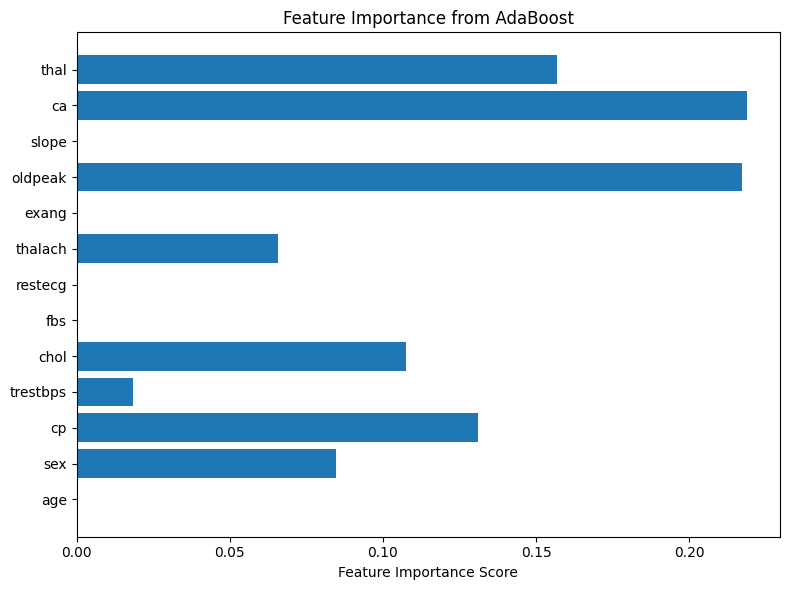


Top important features:
    Feature  Importance
11       ca    0.218690
9   oldpeak    0.217184
12     thal    0.156821
2        cp    0.131099
4      chol    0.107356


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

df = pd.read_csv(url, names=column_names, na_values="?")
df["target"] = df["target"].astype(int)
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)
df = df.dropna()

print("Dataset loaded successfully!")
print(df.head())

X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_pred_train = stump.predict(X_train)
y_pred_test = stump.predict(X_test)

print("\n===== BASELINE DECISION STUMP =====")
print("Train Accuracy :", accuracy_score(y_train, y_pred_train))
print("Test Accuracy  :", accuracy_score(y_test, y_pred_test))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test))

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.3, 1.0]

results = []

print("\n===== ADABOOST TRAINING =====\n")

for n in n_estimators_list:
    for lr in learning_rates:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
            n_estimators=n,
            learning_rate=lr,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        results.append([n, lr, acc])
        print(f"n_estimators={n}, learning_rate={lr} → Test Accuracy = {acc:.4f}")

results_df = pd.DataFrame(results, columns=["n_estimators", "learning_rate", "accuracy"])
best_row = results_df.iloc[results_df["accuracy"].idxmax()]

print("\n===== BEST CONFIGURATION =====")
print(best_row)

best_n = int(best_row["n_estimators"])
best_lr = float(best_row["learning_rate"])

best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=best_n,
    learning_rate=best_lr,
    random_state=42
)

best_model.fit(X_train, y_train)

errors = []

for est in best_model.estimators_:
    pred = est.predict(X_train)
    misclassified = (pred != y_train)
    error = np.mean(misclassified)
    errors.append(error)

alphas = best_model.estimator_weights_

plt.figure(figsize=(6, 4))
plt.plot(range(1, best_n + 1), errors)
plt.xlabel("Boosting Round")
plt.ylabel("Error")
plt.title("Boosting Round vs Training Error")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(1, best_n + 1), alphas)
plt.xlabel("Boosting Round")
plt.ylabel("Alpha (Estimator Weight)")
plt.title("Boosting Round vs Alpha")
plt.tight_layout()
plt.show()

final_pred_train = best_model.predict(X_train)
final_pred_test = best_model.predict(X_test)

print("\n===== FINAL MODEL RESULTS (BEST ADABOOST) =====")
print("Train Accuracy :", accuracy_score(y_train, final_pred_train))
print("Test Accuracy  :", accuracy_score(y_test, final_pred_test))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, final_pred_test))
print("\nClassification Report (Test):\n", classification_report(y_test, final_pred_test))

importances = best_model.feature_importances_

plt.figure(figsize=(8, 6))
plt.barh(X.columns, importances)
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance from AdaBoost")
plt.tight_layout()
plt.show()

print("\nTop important features:")
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importances})
print(feat_imp.sort_values("Importance", ascending=False).head())